## 代码模拟

In [1]:
import pandas as pd
import numpy as np
# 会员等级
years = ['2014', '2015', '2016', '2017', '2018']
memberStatus = ['bronze', 'silver', 'gold', 'inactive']
memberYears = np.random.choice(years, 1000, p=[0.1, 0.1, 0.15, 0.30, 0.35])
memberStats = np.random.choice(memberStatus, 1000, p=[0.5, 0.3, 0.1, 0.1])
yearJoined = pd.DataFrame({'yearJoined': memberYears, 'memberStats': memberStats})


### 模拟打开邮件

In [2]:
NUM_EMAILS_SENT_WEEKLY = 3  # 这个组织每周发送三封电子邮件

# 我们为不同的行为模式定义多个函数
def never_opens(period_rng):
    return []

# 每周打开相同数量的电子邮件
def constant_open_rate(period_rng):
    n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
    num_opened = np.random.binomial(n, p, len(period_rng))      # 生成二项分布随机数
    return num_opened

# 每周打开的电子邮件数量逐渐增多
def increasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(1.01, 1.30))

# 每周打开的电子邮件数量逐渐减少
def decreasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(0.5, 0.99))

# 模拟在给定时间范围 period_rng 内，邮件打开率随着一个因子 fac 的变化
# 确保以相同的方式模拟那些逐渐活跃或逐渐不活跃的会员
def open_rate_with_factor_change(period_rng, fac):
    if len(period_rng) < 1:
        return []
    times = np.random.randint(0, len(period_rng), int(0.1 * len(period_rng)))   # 没有打开的邮件时间
    num_opened = np.zeros(len(period_rng))      # 初始化为0
    for prd in range(0, len(period_rng), 2):
        try:
            n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)  # p:每个邮件被打开的概率
            # 在 prd 和 prd+1 时间点的邮件打开次数 每个时间点的邮件打开次数是根据二项分布生成的
            num_opened[prd:(prd + 2)] = np.random.binomial(n, p, 2)
            p = max(min(1, p * fac), 0) # 在保证p的区间为[0, 1]的同时, 使用fac来决定p是否增加
        except:     # 处理索引报错
            num_opened[prd] = np.random.binomial(n, p, 1)
    for t in range(len(times)):
        num_opened[times[t]] = 0    # 这些时间点没有邮件被打开
    return num_opened


### 模拟捐款

In [3]:
def random_weekly_time_delta():
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11, 23)]   # 假设只在有限的时间活动
    minute_of_hour = [m for m in range(60)]
    second_of_minute = [s for s in range(60)]
    
    return pd.Timedelta(str(np.random.choice(days_of_week)) + " days") + \
           pd.Timedelta(str(np.random.choice(hours_of_day)) + " hours") + \
           pd.Timedelta(str(np.random.choice(minute_of_hour)) + " minutes") + \
           pd.Timedelta(str(np.random.choice(second_of_minute)) + " seconds")

In [4]:
# 捐款行为
def produce_donations(period_rng, member_behavior, num_emails, use_id, member_join_year):
    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500, 1000, 1500, 2000])
    member_has = np.random.choice(donation_amounts)
    email_fraction = num_emails / (NUM_EMAILS_SENT_WEEKLY * len(period_rng)) # 会员在指定时间段内的邮件频率
    member_gives = member_has * email_fraction      # 当前会员的捐款潜力
    # np.where(): 返回满足某个条件的元素的索引
    # np.where(member_gives >= donation_amounts)生成一个bool数组
    # [-1]: 最后一个满足条件的索引
    member_gives_idx = np.where(member_gives >= donation_amounts)[0][-1]
    member_gives_idx = max(min(member_gives_idx, len(donation_amounts) - 2), 1) # >0 :捐款金额为 0不被记录
    # 使用泊松分布 (np.random.poisson(2)) 来模拟会员捐款的次数, 抽取的随机整数
    num_times_gave = np.random.poisson(2) * (2018 - member_join_year)   # 会员在其活动年数内预计进行的捐款次数
    times = np.random.randint(0, len(period_rng), num_times_gave)       # 随机生成了捐款的时间点索引
    
    dons = pd.DataFrame({'member': [], 'amount': [], 'timestamp': []})
    
    for n in range(num_times_gave):
        donation = donation_amounts[member_gives_idx + np.random.binomial(1, .3)]
        ts = str(period_rng[times[n]].start_time + random_weekly_time_delta())
        dons = pd.concat([dons, pd.DataFrame({'member': [use_id], 'amount': [donation], 'timestamp': [ts]})])
    
    if dons.shape[0] > 0:
        dons = dons[dons.amount != 0]  # 我们不会记录捐款金额为0的事件
        # 因为在现实世界中，我们不会记录这种数据
    
    return dons


In [5]:
# 模拟会员的邮件行为和捐款行为
behaviors = [never_opens, constant_open_rate, increasing_open_rate, decreasing_open_rate]
member_behaviors = np.random.choice(behaviors, 1000, [0.2, 0.5, 0.1, 0.2])
rng = pd.period_range('2015-02-14', '2018-06-01', freq='W')
emails = pd.DataFrame({'member': [], 'week': [], 'emailsOpened': []})
donations = pd.DataFrame({'member': [], 'amount': [], 'timestamp': []})

# 假设 yearJoined 是包含会员入会年份的数据框
yearJoined = pd.DataFrame({'yearJoined': np.random.choice([2014, 2015, 2016, 2017], 1000)})

# 遍历每个会员，生成邮件打开和捐款行为
for idx in range(yearJoined.shape[0]):
    # 随机生成会员的入会日期            # iloc: 基于整数索引选择数据
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined) + pd.Timedelta(str(np.random.randint(0, 365)) + ' days')
    join_date = min(join_date, pd.Timestamp('2018-06-01'))

    # 将 join_date 转换为 Period 类型，按周分组
    join_date = pd.to_datetime(join_date).to_period('W')
    # 会员在入会前不应有操作时间戳
    member_rng = rng[rng > join_date]
    
    # 如果该会员没有有效的活动时间段，跳过
    if len(member_rng) < 1:
        continue
    
    # 获取该会员的邮件打开信息
    info = member_behaviors[idx](member_rng)
    
    # 如果邮件打开信息的长度等于活动时间段长度，则记录该会员的行为
    if len(info) == len(member_rng):
        emails = pd.concat([emails, pd.DataFrame({
            'member': [idx] * len(info),
            'week': [str(r.start_time) for r in member_rng],
            'emailsOpened': info
        })])
        
        # 记录该会员的捐款行为
        donations = pd.concat([donations, produce_donations(member_rng, member_behaviors[idx], sum(info), idx, join_date.year)])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7096\1634564508.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num_opened[prd] = np.random.binomial(n, p, 1)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7096\3189594236.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  donations.groupby(pd.Grouper(freq='M')).amount.sum().plot()


<Axes: xlabel='timestamp'>

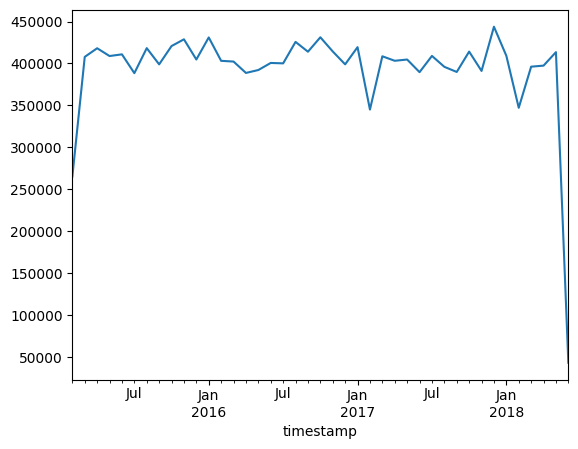

In [6]:
donations.set_index(pd.to_datetime(donations.timestamp), inplace=True)
donations.sort_index(inplace=True)
donations.groupby(pd.Grouper(freq='M')).amount.sum().plot()


In [7]:
donations

,member,amount,timestamp
timestamp,,,
2015-02-09 11:02:14,112.0,250.0,2015-02-09 11:02:14
2015-02-09 11:02:41,469.0,500.0,2015-02-09 11:02:41
2015-02-09 11:02:56,413.0,50.0,2015-02-09 11:02:56
2015-02-09 11:04:32,75.0,50.0,2015-02-09 11:04:32
2015-02-09 11:36:36,160.0,50.0,2015-02-09 11:36:36
...,...,...,...
2018-06-03 21:39:56,470.0,100.0,2018-06-03 21:39:56
2018-06-03 21:42:43,630.0,250.0,2018-06-03 21:42:43
2018-06-03 22:20:57,285.0,50.0,2018-06-03 22:20:57


In [8]:
emails

,member,week,emailsOpened
0,0.0,2015-02-09 00:00:00,0.0
1,0.0,2015-02-16 00:00:00,1.0
2,0.0,2015-02-23 00:00:00,1.0
3,0.0,2015-03-02 00:00:00,2.0
4,0.0,2015-03-09 00:00:00,1.0
...,...,...,...
168,998.0,2018-04-30 00:00:00,1.0
169,998.0,2018-05-07 00:00:00,0.0
170,998.0,2018-05-14 00:00:00,1.0
171,998.0,2018-05-21 00:00:00,2.0
